## PUBG Match Statistics
PUBG is a first/third-person shooter battle royale style game that matches over 90 players on a large island where teams and players fight to the death until one remains. Players are airdropped from an airplane onto the island where they are to scavenge towns and buildings for weapons, ammo, armor and first-aid. Players will then decide to either fight or hide with the ultimate goal of being the last one standing. A bluezone (see below) will appear a few minutes into the game to corral players closer and closer together by dealing damage to anyone that stands within the bluezone and sparing whoever is within the safe zone.

![eq7](https://user-images.githubusercontent.com/54467567/66076454-73260b80-e523-11e9-8c56-846b284029af.PNG)


### Libraries

In [13]:
import os as osvariable
import pandas as pd
import numpy as np
from scipy.stats import norm
import statsmodels.api as st
import statsmodels.formula.api as smf
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split
from statsmodels.base.model import GenericLikelihoodModel
from scipy.special import gamma as gammafunction
from scipy.special import gammainc
from scipy.special import psi
import mpmath
from sympy import DiracDelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
os.chdir(r"C:\Users\priyabrata.thatoi\Downloads\agg_match_stats_0.csv")

### Structuring the dataset

In [14]:
# read the pubg dataset
df=pd.read_csv('agg_match_stats_0.csv')

#check the shape of the dataset
print(df.shape)

#check the number of unique players
print(df['player_name'].nunique())

(13849287, 15)
4269507


In [151]:
#create a dataset with unique players for survival analysis
survival_data=df.drop_duplicates(subset='player_name', keep='first', inplace=False)
print('Shape of the survival dataset ',survival_data.shape)
print(survival_data.dtypes)

Shape of the survival dataset  (4269508, 15)
date                    object
game_size                int64
match_id                object
match_mode              object
party_size               int64
player_assists           int64
player_dbno              int64
player_dist_ride       float64
player_dist_walk       float64
player_dmg               int64
player_kills             int64
player_name             object
player_survive_time    float64
team_id                  int64
team_placement           int64
dtype: object


### Analyzing the dataset

In [152]:
# finding the number of nulls
print(survival_data.isnull().sum())

#remove the row with null value
survival_data.dropna(axis=0,inplace=True)
print(survival_data.shape)

# removing unwanted variables
del_cols = ['date','match_id','team_id','team_placement','match_mode']
survival_data.drop(del_cols,axis=1,inplace=True)
print('shape of the dataset after dropping the null row ',survival_data.shape)

date                   0
game_size              0
match_id               0
match_mode             0
party_size             0
player_assists         0
player_dbno            0
player_dist_ride       0
player_dist_walk       0
player_dmg             0
player_kills           0
player_name            1
player_survive_time    0
team_id                0
team_placement         0
dtype: int64
(4269507, 15)
shape of the dataset after dropping the null row  (4269507, 10)


{'whiskers': [<matplotlib.lines.Line2D at 0xcaf60278>,
 'caps': [<matplotlib.lines.Line2D at 0xcaf82438>,
 'boxes': [<matplotlib.lines.Line2D at 0xcaf60358>],
 'medians': [<matplotlib.lines.Line2D at 0xcaf82b38>],
 'fliers': [<matplotlib.lines.Line2D at 0xcaf82588>],
 'means': []}

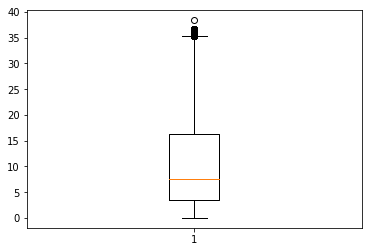

In [154]:
# convert survive time from seconds to minutes
survival_data['player_survive_time'] = round(survival_data['player_survive_time']/60,2)

# Removing outliers from the dataset for any
# variables based on the value of the 
# on the range of IQR
Q1 = survival_data.quantile(0.25)
Q3 = survival_data.quantile(0.75)
IQR = Q3 - Q1
survival_data = survival_data[~((survival_data < (Q1 - 1.5 * IQR)) |(survival_data > (Q3 + 1.5 * IQR))).any(axis=1)]

#plotting the final boxplot for player survive time
plt.boxplot(survival_data.player_survive_time)

### Features 

In [158]:
# Party size (1,2 & 4)
# Party size 1 -- > solo
# Party size 2 -- > duo 
# Party size 4 -- > Squad
#survival_data['party_size_label']=np.nan
#survival_data['party_size_label'][survival_data['party_size']==1]='solo'
#survival_data['party_size_label'][survival_data['party_size']==2]='duo'
#survival_data['party_size_label'][survival_data['party_size']==4]='squad'

# game size ( < 33) -- > small
# game size (33, 66) --> medium
# game size (>66) --> big
#survival_data['game_size'] = survival_data['game_size'].astype('str')
#survival_data['game_size'][(survival_data['game_size'] < '33')]='small'
#survival_data['game_size'][(survival_data['game_size'] >= '33') & (survival_data['game_size'] < '66')]='medium'
#survival_data['game_size'][survival_data['game_size'] >='66']='big'

#survival_data.head()
print(survival_data['player_dbno'].value_counts(normalize=True))

#Removing player_dbno ==2
survival_data=survival_data[survival_data['player_dbno'] != 2]

print(survival_data['player_dbno'].value_counts(normalize=True))

0    0.706092
1    0.238737
2    0.055171
Name: player_dbno, dtype: float64
0    0.747322
1    0.252678
Name: player_dbno, dtype: float64


# Survival Analysis 

<p style='text-align: justify;'> The objective in survival analysis (also referred to as reliability analysis in engineering) is to establish a connection between covariates and the time of an event. What makes survival analysis differ from traditional machine learning is the fact that parts of the training data can only be partially observed – they are censored. For instance, in a clinical study, patients are often monitored for a particular time period, and events occurring in this particular period are recorded. If a patient experiences an event, the exact time of the event can be recorded – the patient’s record is uncensored. In contrast, right censored records refer to patients that remained event-free during the study period and it is unknown whether an event has or has not occurred after the study ended. Consequently, survival analysis demands for models that take this unique characteristic of such a dataset into account.</p>

T is the time from customer's service subscription to the customer churn and it is a discrete & non-negative variable.

1. probability distribution function f(t) where f(t) : [ { s(t) - s(t+dt) } /dt ] 
2. cumulative distribution function F(t)  where F(t) : ∫f(x)dx

#### Survival Function
It defines the probability that the event of interest has not occurred at time t. It can also be interpreted as the probability of survival after time t. Here, T is the random lifetime taken from the population and it cannot be negative. Note that S(t) is between zero and one (inclusive), and S(t) is a non-increasing function of t

\begin{align*}
s(t) = 1-F(t)
\end{align*}


#### Hazard Function
<p style='text-align: justify;'> It also called the intensity function, is defined as the probability that the subject will experience an event of interest within a small time interval, provided that the individual has survived until the beginning of that interval. It is the instantaneous rate calculated over a time period and this rate is considered constant . It can also be considered as the risk of experiencing the event of interest at time t. It is the number of subjects experiencing an event in the interval beginning at time t divided by the product of the number of subjects surviving at time t and interval width </p>

\begin{align*}
 h(t) = [ ( s(t) - s(t+dt) ) /dt ] / S(t)
\end{align*}

\begin{align*}
 h(t) = f(t) / S(t)
\end{align*}

### Kaplan - Meier (Non-Parametric Method)


<p style='text-align: justify;'>As the actual survival function cannot be observed, it is approximated by the Kaplan-Meier (KM) estimator, which essentially calculates the proportion of at-risk subjects that has not yet "succumbed" (to death, malfunction, etc) out of all at-risk subjects present at each time t: </p>

![eq1](https://user-images.githubusercontent.com/54467567/66076093-a74cfc80-e522-11e9-9caf-6c1faf1afbc5.PNG)

<p style='text-align: justify;'> S(t) is the probability of survival with respect to time t, di is the number of clients who have churned at time t, ni is the number of the clients at risk of experiencing churning at time t. This method doesn't use any parameters rather depends only on time and censoring </p>

In [159]:
#Dataset contain 4 continuous variables, 4 categorical variables
#and 1 ID variables(player name). Churn is the target variales 
#containing 0 as right censored data and 1 as
#churned data (observed the event)

#Add constant to the data
#Prepend=False to keep it a dataframe
survival_data=st.add_constant(survival_data,prepend=False)

#Create the event variables. 'Churn' equals 1 if client has
#churned and 'Churn' equals 0 if the client hasn't ended 
#within the observation period
eventvar=survival_data['player_dbno']

#Create the time variables. 'Active_Duration_Months' contains
#tenure of clients in months. it is the difference b/w
#active start date and inactive end date in the data
eventtime=survival_data['player_survive_time']

<lifelines.KaplanMeierFitter: fitted with 2.2662e+06 total observations, 1.69358e+06 right-censored observations>


Text(0.5, 1.0, 'Kaplan-Meier Curve')

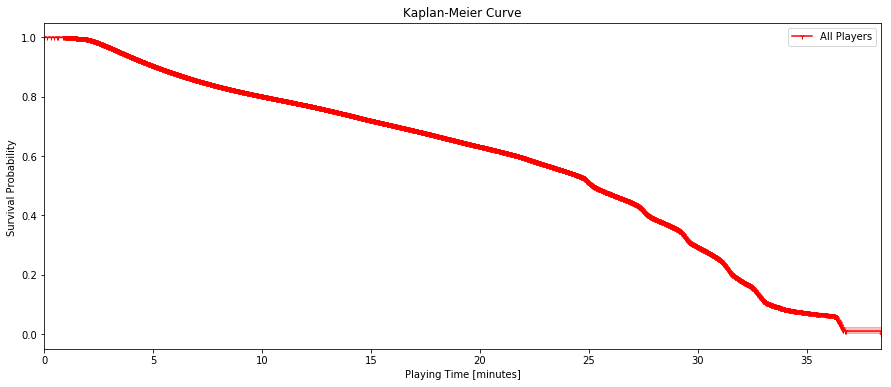

In [160]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()

#Calculate KM Curve for all the group
kmf.fit(eventtime,event_observed=eventvar,label='All Players')
print(kmf)
#Plot the curve and assign label
kmf.plot(figsize=(15,6),color='red',marker="1")
plt.ylabel('Survival Probability ')
plt.xlabel('Playing Time [minutes]')
plt.title('Kaplan-Meier Curve')

This curve represents all the players associated in the dataset and that have a valid survival time.From the above Kaplan-Meier Curve it is evident that most of the players don't survive after 35 minutes of the game play where as about 50 % of the Players died within the first 25 minutes of the game

###### 1. Probability of surviving more than 25 mins is 50%
###### 2. Probability of surviving more than 10 mins is 80 %

### Log Rank Test

Log rank test evaluates the survival rate within each group. under the null hypothesis, the probability of event across each groups is the same for all the time periods . Log rank calculates the difference between the observed number of events and expected number of events to the size of each group at each time period. it follows the chi-sqaure distribition and is calulated as follows :

![eq2](https://user-images.githubusercontent.com/54467567/66076094-a74cfc80-e522-11e9-8b73-7254833c99d2.PNG)

Text(0, 0.5, 'Probability of Survival')

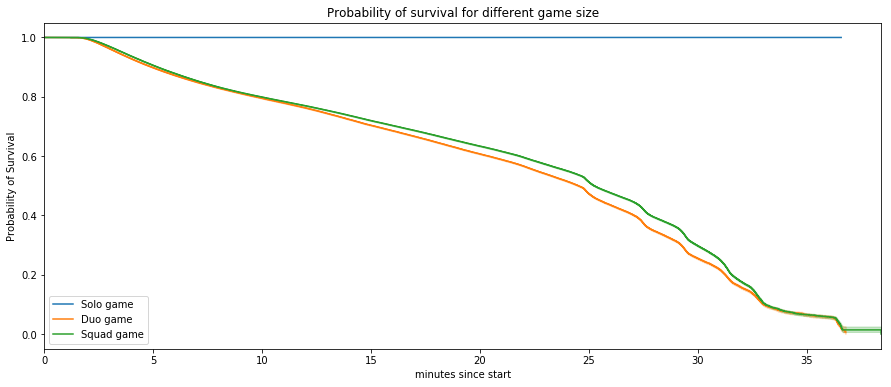

In [164]:
# Analyzing Survival probability for different player size : Solo | Duo | Squad

#create group specific eventvar and timevar
eventvar1=survival_data['player_dbno'][survival_data['party_size']==1]
eventtime1=survival_data['player_survive_time'][survival_data['party_size']==1]
eventvar2=survival_data['player_dbno'][survival_data['party_size']==2]
eventtime2=survival_data['player_survive_time'][survival_data['party_size']==2]
eventvar4=survival_data['player_dbno'][survival_data['party_size']==4]
eventtime4=survival_data['player_survive_time'][survival_data['party_size']==4]


#start a new plot
plt.figure(figsize=(15,6))
ax=plt.subplot(1,1,1)
#Fit the K-M curve to observations for which Zone=South
kmf.fit(eventtime1,eventvar1,label='Solo game')
plot1=kmf.plot(ax=ax)
#Fit the K-M curve to observations for which Zone = Midwest
kmf.fit(eventtime2,eventvar2,label='Duo game')
plot2=kmf.plot(ax=plot1)
#Fit the K-M curve to observations for which Zone = North-East
kmf.fit(eventtime4,eventvar4,label='Squad game')
plot3=kmf.plot(ax=plot2)

plt.title('Probability of survival for different game size')
plt.xlabel('minutes since start')
plt.ylabel('Probability of Survival')

Survivality of the solo players are very high as compared to survivality of the duo and squad players. Howcver, between Duo and Squad players, Squad players have high probability of surviving which is obvious as multiple players are involved in the game to protect each others which is lacking in the case of the Duo. In case of the Solo, players has to make his own call and don't have rely on any other players that gives him more survival opportunity and hence is the fittest surviving player in the game . To further test the hypothesis if different groups have different survival probability, log rank test is conducted as below

In [168]:
#log rank test for more than 2 groups to check
#if the survival rates are same for each group
twoplusgroups_logrank = multivariate_logrank_test(survival_data['player_survive_time'],
                                                  survival_data['party_size'],
                                                  survival_data['player_dbno'],
                                                  alpha = 0.95)
#
twoplusgroups_logrank.print_summary()

# Survival probability is different for different party size ( solo | duo | squad )
# as p value is  < 0.05 and that rejects the null hypothesis

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.95

---
 test_statistic      p  -log2(p)
       22529.27 <0.005       inf


In [169]:
survival_data.head()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_name,player_survive_time,const
0,37,2,0,1,2870.72400,1784.847780,117,1,SnuffIes,18.44,1.0
1,37,2,0,1,2938.40723,1756.079710,127,1,Ozon3r,18.44,1.0
2,37,2,0,0,0.00000,224.157562,67,0,bovize,3.93,1.0
3,37,2,0,0,0.00000,92.935150,0,0,sbahn87,3.29,1.0
4,37,2,0,0,2619.07739,2510.447000,175,2,GeminiZZZ,25.62,1.0


### Hazard Ratio using Binary Logisitic Model

In [171]:
x = survival_data.drop(['player_dbno','player_name'],axis=1)
y = survival_data['player_dbno']
#y=np.ravel(y)
logreg = st.Logit(y,x)
scoremodel=logreg.fit(method = 'bfgs')
scoremodel.summary()

         Current function value: 0.299516
         Iterations: 35
         Function evaluations: 47
         Gradient evaluations: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            player_dbno   No. Observations:              2266203
Model:                          Logit   Df Residuals:                  2266195
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.4701
Time:                        14:03:18   Log-Likelihood:            -6.7876e+05
converged:                      False   LL-Null:                   -1.2810e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
game_size              -0.1329      0.001   -205.704      0.000      -0.134      -0.132
party_size             -1.0165      0.007   -140.794      0.000      -1.031      -1.002
player_assists               0    202.760          0      1.000    -397.403     397.403
player_dist_ride     3.736e-05   2.41e-06     15.475      0.000    3.26e-05    4.21e-05
player_dist_walk     3.909e-05   4.62e-06      8.460      0.000       3e-05    4.81e-05
player_dmg              0.0222   4.49e-05    494.959      0.000       0.022       0.022
player_kills            1.9356      0.005    416.377      0.000       1.927       1.945
player_survive_time    -0.0518      0.001    -76.497      0.000      -0.053      -0.050
const                   5.0359      0.045    112.270      0.000       4.948       5.124
=======================================================================================
"""

All the factors except player assists are significant in defining player_dbno.

In [174]:
# Hazard Ratio
np.exp(scoremodel.params)

game_size                0.875582
party_size               0.361844
player_assists           1.000000
player_dist_ride         1.000037
player_dist_walk         1.000039
player_dmg               1.022484
player_kills             6.928322
player_survive_time      0.949547
const                  153.833334
dtype: float64

##### Hazard of getting kiled increases with the increase in player_dist_ride/walk
##### Hazard of getting killed increases with the increase in player_dmg
##### Hazard of getting killed increases with the increase in player kills
##### Hazard of getting killed decreases with the increasing in group size
##### Hazard of getting killed decreases with the increasing in game size

### Cox Proportional Hazard Model (Semi-Parametric)
Survival methods can be extended to assess several risk factors simultaneously siilar to multiple linear and logisitic models. one of the popular survival analysis is cox-proportional hazard analysis. The measure of effect is hazard rate, that is the probability of failure provided the participant has survived until time t.
Harzard ratio is analogous to an odd ratio in the setting of multiple logistic regression analysis. it is nothing but the risk of the event of the group in the numerator to the risk of the event of the group in the denominator. it is given by :
![eq3](https://user-images.githubusercontent.com/54467567/66076095-a7e59300-e522-11e9-8138-795678df1c1c.PNG)

One such method is Cox Proportional Hazard Model. It has 3 important assumptions such as 
1. Independence of survival times between distinct individual in the sample
2. a multiplicative relationship between the predictors and the harzard
3. A constant hazard ratio over time

the cox proportional hazard ratio is given by : 
![eq4](https://user-images.githubusercontent.com/54467567/66076096-a7e59300-e522-11e9-87e4-3dc7c3caa3ca.PNG)

In [185]:
#CoxPHFitter takes dataframe that includes time and event variables
#CoxPH model does't estimate Beta for constant so remove constant
survival_data = survival_data.dropna()
survivalCPH=survival_data.drop(columns=['const','player_name'])
survivalCPH=survivalCPH.drop(columns=['player_assists','game_size'])
#Create dummy variables
#survivalCPH = pd.get_dummies(survivalCPH,columns=['Zone'],prefix='::',drop_first=True)
cph=CoxPHFitter()
#fit the model
cph.fit(survivalCPH,'player_survive_time',event_col='player_dbno')
#Summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2.2662e+06 total observations, 1.69358e+06 right-censored observations>
      duration col = 'player_survive_time'
         event col = 'player_dbno'
number of observations = 2266203.0
number of events observed = 572619.0
partial log-likelihood = -7254535.14
  time fit was run = 2019-10-02 19:16:25 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
party_size        0.21      1.23      0.00            0.21            0.21                1.23                1.23
player_dist_ride -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
player_dist_walk -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
player_dmg        0.01      1.01      0.00            0.01            0.01                1.01                1.01
player_kills      0.58      1.79      0.00            0.58            0.59      

###### From the Cox Proportional Hazard Model it is evident that, hazard of getting killed is positively affected by party size, player_dmg & player_kills where as it is negatively affected by player_dist_ride/walk. The concordance pair which means higher probability of hazard is termed as 1, such pairs are 90% in our dataset

#### Conclusion :
1. Making the character walk or run doesn't really has any effect of its survival
2. Number of players/enemies kill could drastically increase survival rate
3. Increase the number of players in the team could increase the survival rate as compared to solo/duo